## Notebook to examine error (standard deviation) of TCS_CAGR using bootstrap method
This is estimated for TCS_CAGR for 1998-2010 literature

In [1]:
import pandas as pd
import h5py
import os, sys

sys.path.append("../src")
from process import *

In [2]:
# Config section
version = '19_2_125_rec1'

viz_data_filename = f"../data/viz_data_{version}.hdf5"
Start_Year = 1998
End_Year = 2010

# viz 19 (125 topics)
topics_to_estimate_errors = [29, 32, 45, 64, 70, 74, 91, 95, 97, 120]

In [3]:
years = range(Start_Year, End_Year+1)
    
data = load_topic_bibcode_h5py(viz_data_filename)
data.reset_index(drop=True, inplace=True)
data = data[data['year']>=Start_Year]
data = data[data['year']<=End_Year]
data = data.sort_values('year')
# data

In [4]:
data_by_year = { year-Start_Year:data[data['year']==year].reset_index(drop=True) for year in [Start_Year, End_Year] }

In [5]:
data_by_year.keys()

dict_keys([0, 12])

In [6]:
data_by_year[12]

,0,1,2,3,4,5,6,7,8,9,...,116,117,118,119,120,121,122,123,124,year
0,0.001949,0.002054,0.002114,0.002039,0.001897,0.002011,0.001992,0.001998,0.251716,0.002140,...,0.001952,0.001991,0.002070,0.001966,0.001999,0.002064,0.002038,0.002027,0.002007,2010
1,0.001300,0.001370,0.001410,0.001360,0.001265,0.001341,0.001329,0.001332,0.001417,0.001427,...,0.001302,0.001328,0.001381,0.001312,0.001333,0.001377,0.001360,0.001352,0.001338,2010
2,0.001560,0.001644,0.001692,0.001632,0.001518,0.001609,0.001594,0.001599,0.001700,0.001712,...,0.001562,0.001593,0.001656,0.001574,0.001599,0.001652,0.001631,0.001622,0.001606,2010
3,0.001949,0.002054,0.002114,0.002039,0.001897,0.002011,0.001992,0.001998,0.002125,0.002139,...,0.001952,0.001991,0.002070,0.001966,0.001999,0.002064,0.002038,0.002027,0.002007,2010
4,0.000975,0.001028,0.202363,0.001021,0.000949,0.001006,0.000997,0.001000,0.001063,0.001071,...,0.000977,0.000996,0.001036,0.000984,0.001000,0.001033,0.001020,0.001014,0.001004,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7109,0.000650,0.000685,0.000705,0.084681,0.000633,0.000671,0.000665,0.000667,0.000709,0.000714,...,0.000651,0.000664,0.000691,0.000656,0.242831,0.084209,0.000680,0.000676,0.000670,2010
7110,0.002597,0.002737,0.002817,0.002718,0.002528,0.339128,0.002655,0.002662,0.002831,0.002851,...,0.002601,0.002653,0.002758,0.002621,0.002663,0.002751,0.002716,0.002701,0.002674,2010
7111,0.001560,0.001644,0.001692,0.001632,0.001518,0.001609,0.001594,0.001599,0.001700,0.551652,...,0.001562,0.001593,0.001656,0.001574,0.001599,0.001652,0.001631,0.001622,0.001606,2010
7112,0.003891,0.004101,0.004221,0.004072,0.003788,0.004016,0.003978,0.003989,0.004242,0.004272,...,0.003897,0.003975,0.004133,0.003926,0.003991,0.004122,0.004070,0.004047,0.004007,2010


In [7]:

import numpy as np
import statistics

# cagr calculation
def cagr (low:float, high:float, time:int)->float:
    return (high/low)**(1/time) - 1.


# sample timeseries data for bootstrap
import random
def sample_timeseries(topic, data_by_year:dict, samples_per_year:int=100, threshold:float=0.0):
    
    ''' random sample, no replacement '''
    num_topics = len(data_by_year[0].columns)-1
    #timeseries = { topic:{ yr:0. for yr in data_by_year.keys()} for topic in range(0,num_topics) }
    timeseries = [0. for i in range(0, len(data_by_year.keys()))]
    
    # using random sampling of the rows
    # calculate timeseries for each topic
    # just Pick off first and last years
    for year in [0, 1]: #data_by_year.keys():
        
        #print (year)
        data = data_by_year[year * (End_Year-Start_Year)]
        #print (data)
        row_seq = list(range(0, len(data)))
        #print (row_seq)
        
        try:
            random_rows = random.sample(row_seq, samples_per_year)
        except Exception as ex:
            print (f"Fail on topic {topic}")
            raise ex
            
        for random_row in random_rows:
            row_data = data[data.index==random_row]
            value = list(row_data[topic].values)[0]
            
            # dont co-add if below this threshold
            if value >= threshold:
                timeseries[year] += value

    return timeseries

# sample timeseries data for bootstrap
def sample_timeseries_repl(topic, data_by_year:dict, samples_per_year:int=100, threshold:float=0.0):
    
    ''' random sample with replacement. '''
    num_topics = len(data_by_year[0].columns)-1
    #timeseries = { topic:{ yr:0. for yr in data_by_year.keys()} for topic in range(0,num_topics) }
    timeseries = [0. for i in range(0, len(data_by_year.keys()))]
    
    # using random sampling of the rows
    # calculate timeseries for each topic
    # just pick off start and end years
    for year in [0, 1]:# data_by_year.keys():
        
        #print (year)
        data = data_by_year[year * (End_Year-Start_Year)]
        #print (data)
        row_seq = list(range(0, len(data)))
        #print (row_seq)
        
        for i in range(0, samples_per_year):
            
            random_row = random.choice(row_seq)
            row_data = data[data.index==random_row]
            value = list(row_data[topic].values)[0]
            
            # dont co-add if below this threshold
            if value >= threshold:
                timeseries[year] += value

    return timeseries

def bootstrap_estimate (topic:int, data_by_year:dict, \
                       num_times_to_sample:int=10, num_data_samples:int=10000,\
                       replacement:bool=True):
    
    """ Returns the standard deviation for selected topic timeseries CAGR values """
    
    stats = []
    for i in range(0, num_times_to_sample):
        if replacement:
            timeseries = pd.Series(sample_timeseries_repl(topic, data_by_year, num_data_samples))
        else:
            timeseries = pd.Series(sample_timeseries(topic, data_by_year, num_data_samples))
            
        #print (timeseries)
        #t_size = len(timeseries)-1
        t_start = timeseries[0]      
        t_end = timeseries[1]

        #print (f"s:%s e:%s size:%s" % (t_start, t_end, t_size))
        if t_start != 0:
            v = cagr(t_start, t_end, 13)
            #print(f"   cagr:{v}")
            stats.append(v)
    
    #calculate mean, standard deviation
    return statistics.mean(stats), np.std(stats)
    


In [8]:
# choose to sample ~70% of the smallest year size
len(data_by_year[0]) * 0.7

3524.5

In [9]:
import time
start_time = time.time()

# bootstrap w/replacement is same as w/o replacement according to:
#  https://stats.stackexchange.com/questions/69744/why-at-all-consider-sampling-without-replacement-in-a-practical-application
# when applied to first-order statistics like mean and variance. w/o replacement should
# be used for higher order statistics (e.g. skewness, kurtosis)

# takes about 64 sec per ~18000 data samples per topic 
#result = bootstrap_estimate(64, data_by_year, 10, 18000)
#print (f" time to run: %5.2f sec" % (time.time()-start_time))
#result

In [10]:
# Do the bootstrap estimate
results = {}
for topic in topics_to_estimate_errors:
    print (f"Doing topic: {topic}")
    results[topic] = bootstrap_estimate(topic, data_by_year, 10, 18000, replacement=True)
    #result = bootstrap_estimate(64, data_by_year, 10, 18000)

Doing topic: 29
Doing topic: 32
Doing topic: 45
Doing topic: 64
Doing topic: 70
Doing topic: 74
Doing topic: 91
Doing topic: 95
Doing topic: 97
Doing topic: 120


In [11]:
results

{29: (-0.013897170483903742, 0.003997885658803253),
 32: (-0.0035145457778138047, 0.0031266646419539795),
 45: (-0.010939574986418765, 0.003383838694990032),
 64: (-0.010739712027367333, 0.003542870451951494),
 70: (0.00788017616529042, 0.004737527140543542),
 74: (-0.010145677345778592, 0.003954103626057031),
 91: (0.001971016530246961, 0.005868403150740537),
 95: (0.025481511965275084, 0.004877524303233464),
 97: (0.046823470447995105, 0.0055416619033736795),
 120: (-0.007287397414768237, 0.0040901030878574265)}

In [12]:
topics = [t for t in results.keys()]
mean   = [results[t][0] for t in topics]
std    = [results[t][1] for t in topics]
#cagr = [timeseries_data['cagr'][t] for t in topics]
r_data = pd.DataFrame({'topic':topics, 'mean':mean, 'std':std})

# save it
r_data.to_csv(f'../results/bootstrap_error_est_results_tcs_cagr_repl_1998-2010_{version}.csv')
r_data

,topic,mean,std
0,29,-0.013897,0.003998
1,32,-0.003515,0.003127
2,45,-0.010940,0.003384
3,64,-0.010740,0.003543
4,70,0.007880,0.004738
5,74,-0.010146,0.003954
6,91,0.001971,0.005868
7,95,0.025482,0.004878
8,97,0.046823,0.005542
9,120,-0.007287,0.004090


In [13]:
r_data['std'].mean()

0.004312058265950444

<Axes: title={'center': 'Bootstrap Error Estimation\nTCS_CAGR'}, xlabel='mean', ylabel='std'>

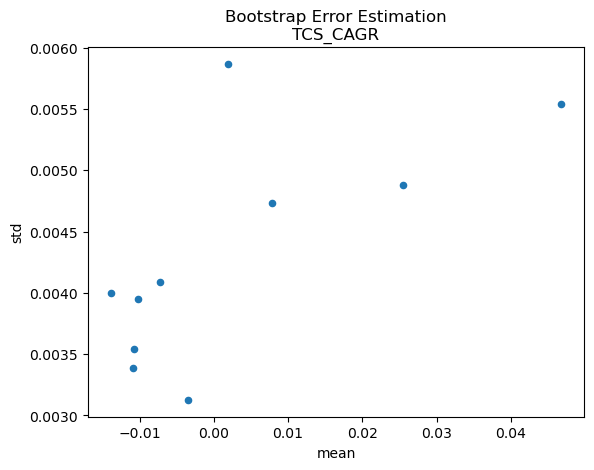

In [14]:
r_data.plot(kind='scatter', x='mean', y='std', title="Bootstrap Error Estimation\nTCS_CAGR")